# Compute Timelags: High Frequency Heating

In [1]:
import os
import sys

import numpy as np
import distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../../scripts/')
from timelags import AIATimeLags
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Spin up a Dask distributed cluster.

In [2]:
cluster = distributed.LocalCluster(threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35945 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Load the data and write it to a single HDF5 file. This makes data access later on much easier.

In [3]:
FREQUENCY = 'high'

In [4]:
aia = InstrumentSDOAIA([5000,25000]*u.s, None)
aia.counts_file = f'/storage-home/w/wtb2/data/timelag_synthesis_v2/{FREQUENCY}_frequency/nei/SDO_AIA_counts.h5'

In [5]:
tl = AIATimeLags(
    aia,
    f'/storage-home/w/wtb2/data/timelag_synthesis_v2/{FREQUENCY}_frequency/nei/timelags/mapcube.h5',
    #fits_root_path=f'/storage-home/w/wtb2/data/timelag_synthesis_v2/{FREQUENCY}_frequency/nei/'
)

Plot a pixel-averaged light curve from the data we loaded.

In [6]:
xc,yc = -325*u.arcsec, -200*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
for i,channel in enumerate(aia.channels,):
    ts = tl.make_timeseries(channel['name'],lower_left_corner,upper_right_corner)
    ax.plot(aia.observing_time,ts/ts.max(),color=f'C{i}',label=channel['name'])
ax.legend()

And then plot the timelags for this same group of averaged pixels for a selected number of channel pairs.

In [7]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [ ]:
fig = plt.figure(figsize=(15,8),)
ax = fig.gca()
for i,p in enumerate(channel_pairs,):
    # cooling
    cc = tl.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(tl.timelags,cc/cc.max(), color=f'C{i%10}', ls='-', label='{}-{}'.format(*p))
    ax.axvline(x=0,ls='--',color='k')
#axes[0,0].set_xlim([-5e3,5e3])
ax.legend(loc=2)

Now, compute the timelag and correlation maps for all of the channel pairs.

In [8]:
timelag_bounds = (-6*u.hour,6*u.hour)

In [9]:
timelag_maps = {}
correlation_maps = {}
with ProgressBar(len(channel_pairs),ipython_widget=True) as prog:
    for p in channel_pairs:
        tl_map, cor_map = tl.make_timelag_map(f'{p[0]}',f'{p[1]}', timelag_bounds=timelag_bounds, return_correlation_map=True)
        timelag_maps['{}-{}'.format(*p)] = tl_map
        correlation_maps['{}-{}'.format(*p)] = cor_map
        prog.update()

FloatProgress(value=0.0)

And plot the maps.

In [10]:
correlation_cutoff = 500.0

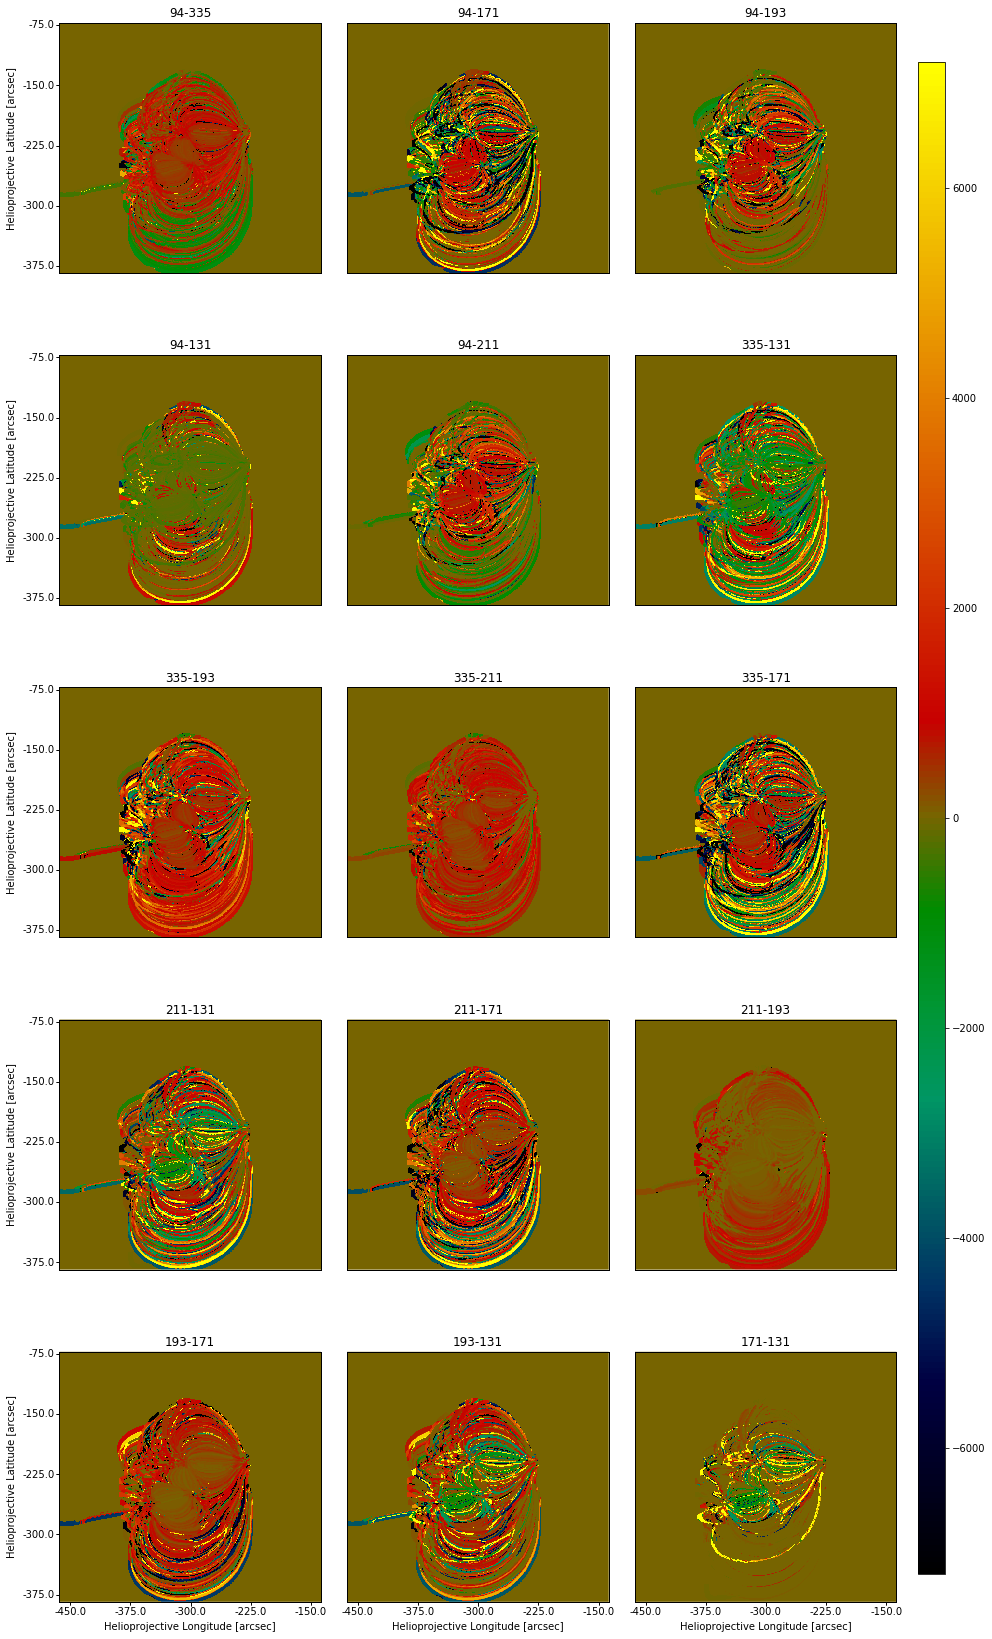

In [12]:
fig = plt.figure(figsize=(15,30))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = Map(timelag_maps['{}-{}'.format(*cp)])
    m_cor = Map(correlation_maps['{}-{}'.format(*cp)])
    data = np.where((m_cor.data) < correlation_cutoff, 0., m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(5, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(2*u.hour).to(u.s).value,
                vmax=(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 11:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

In [ ]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = correlation_maps['{}-{}'.format(*cp)]
    data = np.where(m.data < correlation_cutoff, np.nan, m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0, vmax=3.5e3, cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

Finally, we want to save the maps for all of the channel pairs so that we can analyze them later.

In [13]:
# save maps here
fitsfile = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{frequency}_frequency/nei/timelags/{type}_{c0}_{c1}.fits'
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)].save(fitsfile.format(frequency=FREQUENCY, type='timelag', c0=p[0], c1=p[1]))
    correlation_maps['{}-{}'.format(*p)].save(fitsfile.format(frequency=FREQUENCY, type='correlation', c0=p[0], c1=p[1]))